In [2]:
import tskit
import msprime
import stdpopsim
import networkx as nx
import matplotlib.pyplot as plt
import io
from IPython.display import display as SVG
import sys
import tszip
import pandas as pd
import numpy as np

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [4]:
#visualize pedigrees
def draw_pedigree(ped_ts):
    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

In [5]:
pb = msprime.PedigreeBuilder(
    individuals_metadata_schema=tskit.MetadataSchema.permissive_json())
mom_id = pb.add_individual(time=1, metadata={"name": "mom"})
dad_id = pb.add_individual(time=1, metadata={"name": "dad"})
pb.add_individual(
    time=0, parents=[mom_id, dad_id], is_sample=True, metadata={"name": "child"})
pedigree = pb.finalise()
display(pedigree.nodes)

id,flags,population,individual,time,metadata
0,0,0,0,1,
1,0,0,0,1,
2,0,0,1,1,
3,0,0,1,1,
4,1,0,2,0,
5,1,0,2,0,


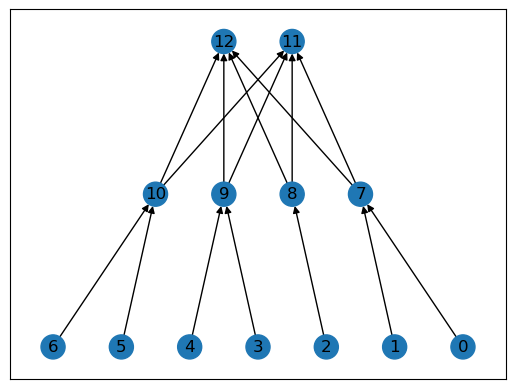

In [6]:
#example pedigrees
#id doesnt matter except for parent child relationships
ped_txt = """\
# id parent0 parent1 time
0 7 7 0.0
1 7 7 0.0
2 8 8 0.0
3 9 9 0.0
4 9 9 0.0
5 10 10 0.0
6 10 10 0.0
7 11 12 1.0
8 11 12 1.0
9 11 12 1.0
10 11 12 1.0
11 . . 2.0
12 . . 2.0
"""

pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length = 100)

draw_pedigree(pedigree.tree_sequence())

In [28]:
#define functions for building pedigrees for breeding

#transform text to pd df
#df = pd.read_table(io.StringIO(ped_txt))
#transform pd df to text
#print(df.to_string())

#generate pedigree df with n "founder" individuals
def pedigree_init(n = 10):
    pedigree = pd.DataFrame(
    {"id": [i for i in range(0, n)],
    "parent0": ["."]*n,
    "parent1": ["."]*n,
    "time": [0]*n})
    return pedigree

#generate msprime trees from df
def df_to_ts(df, seq_len = 100):
    ped_string = df.to_string(index = False)
    ts_ped = msprime.parse_pedigree(io.StringIO("#" + ped_string), sequence_length = seq_len)
    return ts_ped

#selfing (adding selfed individual to pedigree)
def add_selfing(df, size_diff = 0):
    df['time'] += 1
    parents = df.loc[df['time'] == df['time'].min(), "id"].to_numpy()
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + len(parents) + size_diff)]
    df = pd.concat(objs=(df, pd.DataFrame({"id" : ids, "parent0": np.resize(parents, len(parents) + size_diff),
                                           "parent1": np.resize(parents, len(parents) + size_diff),
                                           "time" : [0]*(len(parents) + size_diff)}))).reset_index(drop = True)
    return(df)

#random mating
#implement chance of selfing
def add_random_mating(df, size_diff = 0):
    df['time'] += 1
    parents = df.loc[df['time'] == df['time'].min(), "id"].to_numpy()
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + len(parents) + size_diff)]
    df = pd.concat(objs=(df, pd.DataFrame({"id" : ids, "parent0": np.random.choice(parents, len(parents) + size_diff),
                                           "parent1": np.random.choice(parents, len(parents) + size_diff),
                                           "time" : [0]*(len(parents) + size_diff)}))).reset_index(drop = True)
    return(df)
    
#selective mating
def add_selective_mating(df, parents, offspring = 1):
    df['time'] += 1
    max_id = df.loc[df['id'].max(), "id"]
    ids = [i for i in range(max_id + 1, max_id + 1 + offspring)]
    df = pd.concat(objs=(df, pd.DataFrame({"id": ids, "parent0": np.resize(parents[0], offspring),
                                           "parent1": np.resize(parents[1], offspring),
                                           "time": [0]*offspring}))).reset_index(drop = True)     
    return(df)


#combine n choose 2 (assuming two different parents) or list of crosses. out: n choose 2 pb classes

In [30]:
df = pedigree_init(5)

In [31]:
df = add_selfing(df, size_diff = 5)

In [32]:
add_select_mating(df, list([10,11]), offspring = 5)

,id,parent0,parent1,time
0,0,.,.,2
1,1,.,.,2
2,2,.,.,2
3,3,.,.,2
4,4,.,.,2
5,5,0,0,1
6,6,1,1,1
7,7,2,2,1
8,8,3,3,1
9,9,4,4,1


In [36]:
add_selfing(df, size_diff = 5)

,id,parent0,parent1,time
0,0,.,.,1
1,1,.,.,1
2,2,.,.,1
3,3,.,.,1
4,4,.,.,1
5,5,0,0,0
6,6,1,1,0
7,7,2,2,0
8,8,3,3,0
9,9,4,4,0


In [37]:
add_random_mating(df, size_diff = 5)

,id,parent0,parent1,time
0,0,.,.,2
1,1,.,.,2
2,2,.,.,2
3,3,.,.,2
4,4,.,.,2
5,5,4,1,0
6,6,3,3,0
7,7,1,4,0
8,8,0,0,0
9,9,4,3,0


In [41]:
#generate pedigrees for breeding scheme

#bulk selection
def bulk_method(n = 10, selfing_genos = 2, random_mating_genos = 2, rm_size_diff = 10, selection_step = [20, 5, 1]):
    df = pedigree_init(n)
    for i in range(0, selfing_genos):
        df = add_selfing(df)
    parent_size = len(df.loc[df['time'] == df['time'].min(), "id"])
    if (parent_size+rm_size_diff) < 0:
        raise ValueError('Random mating size difference eliminates all individuals!')
    df = add_random_mating(df, size_diff = rm_size_diff)
    for i in range(0, random_mating_genos - 1):
        #selection step or natural selection!
        df = add_random_mating(df)
    for i in range(0, len(selection_step)):
    #selection steps each!    
        parent_size = len(df.loc[df['time'] == df['time'].min(), "id"])
        if (parent_size-selection_step[i]) < 0:
            raise ValueError('Selection_step bigger than remaining individuals!')
        df = add_selfing(df, size_diff = -parent_size+selection_step[i])    
    return(df)


#single seed descent

#...

In [42]:
bulk_ped = bulk_method(n = 5, selfing_genos = 3, random_mating_genos = 2, rm_size_diff = 3, selection_step = [7, 5, 2])

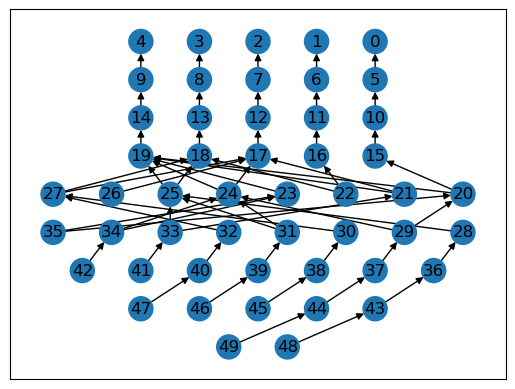

In [43]:
draw_pedigree(df_to_ts(bulk_ped).tree_sequence())

In [44]:
bulk_ts = df_to_ts(bulk_ped)

In [47]:
rate_map = msprime.RateMap(position=[0, 10, 100], rate=[0.01, 0.1])

In [48]:
ped_ts = msprime.sim_ancestry(
    initial_state=bulk_ts, model="fixed_pedigree", random_seed=42, recombination_rate = rate_map)

In [33]:
#print ancestry
def draw_ancestry(ts):
    node_labels = {node.id: f"{node.individual}({node.id})" for node in ts.nodes()}
    SVG(ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(1600,200)))

In [50]:
ped_ts.breakpoints(as_array = True)

array([  0.,   9.,  10.,  11.,  12.,  13.,  15.,  18.,  19.,  20.,  21.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  33.,  34.,
        37.,  38.,  39.,  40.,  41.,  44.,  45.,  46.,  47.,  48.,  49.,
        50.,  52.,  54.,  55.,  56.,  57.,  60.,  61.,  62.,  63.,  64.,
        65.,  66.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  86.,  87.,  88.,  91.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100.])

In [98]:
segments = ped_ts.ibd_segments(store_pairs = True, store_segments = True)
for pair, value in segments.items():
    print(pair, "::", value)
print(segments)

(96, 97) :: IdentitySegmentList(num_segments=1, total_span=100.0)
(98, 99) :: IdentitySegmentList(num_segments=1, total_span=100.0)
╔════════════════════╗
║IdentitySegments    ║
╠══════════════╤═════╣
║Parameters:   │     ║
║max_time      │  inf║
║min_span      │    0║
║store_pairs   │ True║
║store_segments│ True║
║Results:      │     ║
║num_segments  │    2║
║total_span    │200.0║
║num_pairs     │    2║
╚══════════════╧═════╝



In [99]:
segments

IdentitySegments({(96, 97): IdentitySegmentList([IdentitySegment(left=0.0, right=100.0, node=72)]), (98, 99): IdentitySegmentList([IdentitySegment(left=0.0, right=100.0, node=89)])})

In [100]:
print(ped_ts.dump_tables())

TableCollection

Sequence Length: 100.0
Time units: generations
Metadata: b''

Individuals
╔══╤═════╤════════╤═══════╤═════════════════╗
║id│flags│location│parents│metadata         ║
╠══╪═════╪════════╪═══════╪═════════════════╣
║0 │    0│        │ -1, -1│ {'file_id': '0'}║
║1 │    0│        │ -1, -1│ {'file_id': '1'}║
║2 │    0│        │ -1, -1│ {'file_id': '2'}║
║3 │    0│        │ -1, -1│ {'file_id': '3'}║
║4 │    0│        │ -1, -1│ {'file_id': '4'}║
║5 │    0│        │   0, 0│ {'file_id': '5'}║
║6 │    0│        │   1, 1│ {'file_id': '6'}║
║7 │    0│        │   2, 2│ {'file_id': '7'}║
║8 │    0│        │   3, 3│ {'file_id': '8'}║
║9 │    0│        │   4, 4│ {'file_id': '9'}║
║10│    0│        │   5, 5│{'file_id': '10'}║
║11│    0│        │   6, 6│{'file_id': '11'}║
║12│    0│        │   7, 7│{'file_id': '12'}║
║13│    0│        │   8, 8│{'file_id': '13'}║
║14│    0│        │   9, 9│{'file_id': '14'}║
║15│    0│        │ 10, 10│{'file_id': '15'}║
║16│    0│        │ 11, 11│{'file_i

In [102]:
genos = pd.read_csv("data/test_data/genos_reduce.csv")

In [103]:
genos = genos.iloc[:,0:10]

In [104]:
pure_genos = genos.iloc[:,1:len(genos.columns)]

In [105]:
#propagate geno functions
def get_set(ts):
    return(list(set(ts.edges_parent).union(set(ts.edges_child))))

def get_founders(ts):
    return(list(set(ts.edges_parent) - set(ts.edges_child)))

def get_offspring(ts):
    return(list(set(ts.edges_child) - set(ts.edges_parent)))

def get_edges(parents, ts):
    pc_df = pd.DataFrame({"left": ts.edges_left, "right": ts.edges_right, "parent" : ts.edges_parent, "child" : ts.edges_child})
    children = pc_df.loc[pc_df["parent"].isin(parents),]
    return(children)

#replace snp_ids with df of snp + position
def propagate_geno(ts, genotypes, snp_ids):
    geno_sim = pd.DataFrame(columns = list(["node"]) + list(snp_ids))
    geno_sim["node"] = get_set(ts)
    founders = get_founders(ts)
    sites = len(pure_genos.columns)
    for i in range(0, len(founders)):
        geno_sim.loc[geno_sim["node"] == founders[i], pure_genos.columns] = list(pure_genos.iloc[founders[i]])

    edges = get_edges(founders,ts)

    while edges.empty != True:
        for i in range(0, len(edges["parent"])):
            #replace SNPS with function that takes left and right and SNP names between them from SNP+position df
            snps = pure_genos.columns[round((edges.iloc[i]["left"]/100)*sites):round((edges.iloc[i]["right"]/100)*sites)]
            geno_sim.loc[geno_sim["node"] == edges.iloc[i]["child"], snps] = geno_sim.loc[geno_sim["node"] == edges.iloc[i]["parent"], snps].values[0]
        edges = get_edges(edges["child"], ts)
    
    
    return(geno_sim)

In [106]:
geno_prop = propagate_geno(ped_ts, pure_genos, pure_genos.columns)

In [107]:
geno_prop

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1
0,0,0,0,0,0,0,0,0,0,0
1,96,0,0,0,0,0,0,0,0,0
2,97,0,0,0,0,0,0,0,0,0
3,98,2,2,2,2,2,2,2,2,2
4,99,2,2,2,2,2,2,2,2,2
5,5,2,2,2,2,2,2,2,2,2
6,6,2,2,2,2,2,1,1,0,0
7,72,0,0,0,0,0,0,0,0,0
8,89,2,2,2,2,2,2,2,2,2


In [108]:
geno_prop.loc[geno_prop["node"].isin(get_offspring(ped_ts))]

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1
1,96,0,0,0,0,0,0,0,0,0
2,97,0,0,0,0,0,0,0,0,0
3,98,2,2,2,2,2,2,2,2,2
4,99,2,2,2,2,2,2,2,2,2


In [26]:
print(ped_ts)

╔═══════════════════════════╗
║TreeSequence               ║
╠═══════════════╤═══════════╣
║Trees          │          4║
╟───────────────┼───────────╢
║Sequence Length│        100║
╟───────────────┼───────────╢
║Time Units     │generations║
╟───────────────┼───────────╢
║Sample Nodes   │          6║
╟───────────────┼───────────╢
║Total Size     │    7.7 KiB║
╚═══════════════╧═══════════╝
╔═══════════╤════╤═════════╤════════════╗
║Table      │Rows│Size     │Has Metadata║
╠═══════════╪════╪═════════╪════════════╣
║Edges      │  16│520 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Individuals│  55│  2.8 KiB│         Yes║
╟───────────┼────┼─────────┼────────────╢
║Migrations │   0│  8 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Mutations  │   0│ 16 Bytes│          No║
╟───────────┼────┼─────────┼────────────╢
║Nodes      │ 110│  3.0 KiB│          No║
╟───────────┼────┼─────────┼────────────╢
║Populations│   1│224 Bytes│         Yes║
╟───────────┼────┼────

In [20]:
#selection step (see essentials of plant breeding) prune pedigree
#either stepwise (prediction and selection in each step with caveats (only possible in selfing generations))
#or simulate entire breeding ibds and predict final phenotype, simulate all generations

In [21]:
#predict Y (see rf or dl files)